# Vanilla Policy Gradient

## Importing libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from IPython.display import display, clear_output
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

from utils.plots import *
from utils.models import *

## Config

In [24]:
CONFIG = {
    'VPG': {
        'linear': {
            'gamma': 0.99,
            'num_episodes': 2500,
            'policy_lr': 1e-3,
            'val_fn_lr': 1e-3,
            'val_fn_epochs': 10,
        },
        'mlp': {
            'gamma': 0.99,
            'num_episodes': 1000,
            'policy_lr': 1e-3,
            'val_fn_lr': 1e-3,
            'val_fn_epochs': 10,
            'val_fn_hidden_sizes': [16],
        }
    },
    'MLPPolicy_hidden_sizes': [32],
    'animation': {
        'FPS': None,
        'do_truncate': True,
    },
    'plots_info': {
        'subplt_shape': (1,2),
        'figsize': (12,4),
        'subplts_info': [
            {'key': "rewards",
            'title': "Smoothed Rewards",
            'xlabel': "Episodes",
            'ylabel': "Reward"},
            
            {'key': "val_loss",
            'title': "Smooth Value Function Loss",
            'xlabel': "Episodes",
            'ylabel': "Loss"}
        ],
    }
}

## Creating the environment

In [8]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

## Vanilla Policy Gradient

In [20]:
def VanillaPolicyGradient(env, policy, gamma = 1.0, num_episodes = 10, policy_lr = 1e-4,
              val_fn_lr = 1e-3, val_fn_epochs = 10, val_fn_hidden_sizes = [16]):

    s_dims = env.observation_space.shape[0]
    a_dims = env.action_space.n
    
    stats = {'ep_length': [],
             'completions': 0,
             'val_loss': [],
             'rewards': []}

    
    value_fn = MLP(s_dims, 1, val_fn_hidden_sizes)
    mse_loss = nn.MSELoss()
    
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr = policy_lr)
    value_optimizer = torch.optim.Adam(value_fn.parameters(), lr = val_fn_lr)
    
    for e in range(1, num_episodes + 1):

        if e % 1 == 0 or e == num_episodes:
            print(f'\rEpisode : {e}/{num_episodes} ({100*e/num_episodes:.2f}%)', end = '')
            sys.stdout.flush()

        H = defaultdict(lambda: [])
        T = 0
        s, _ = env.reset()
        reward_sum = 0.0
        while True:
            T += 1
            probs = policy(torch.as_tensor(s))
            a = np.random.choice(list(range(a_dims)), p = probs.detach().numpy())

            s_n, r, terminated, truncated, _ = env.step(a)
            reward_sum += r

            H['s'] += [s]
            H['a'] += [a]
            H['r'] += [r]
            H['log_probs'] += [torch.log(probs[a])]
            
            if terminated or truncated:
                stats['ep_length'] += [T]
                stats['rewards'].append(reward_sum)
                if truncated:
                    stats['completions'] += 1
                break

            s = s_n

        R = 0.0
        H['R_t'] = torch.zeros(T)
        for t in reversed(range(T)):
            R = H['r'][t] + gamma * R
            H['R_t'][t] = R
            

        val_avg_loss = 0.0        
        states_tensor = torch.as_tensor(np.asarray(H['s']), dtype=torch.float32)
        
        for epoch in range(val_fn_epochs):
            H['V_pred'] = value_fn(states_tensor).view(-1)
            
            value_optimizer.zero_grad()
            
            val_loss = mse_loss(H['V_pred'], H['R_t']) 
            val_avg_loss += val_loss.item()
            
            val_loss.backward()
            value_optimizer.step()
            
        val_avg_loss /= val_fn_epochs
        stats['val_loss'] += [val_avg_loss]

        policy_optimizer.zero_grad()

        loss = 0
        for t in range(T):
            advantage = H['R_t'][t] - value_fn(states_tensor[t]).detach()
            loss -= H['log_probs'][t] * advantage

        loss.backward()
        policy_optimizer.step()

    return stats

## Linear Policy 

In [25]:
s_dims = env.observation_space.shape[0]
a_dims = env.action_space.n

lin_policy = LinearPolicyDiscrete(s_dims, a_dims)

stats_lin = VanillaPolicyGradient(env, lin_policy, **CONFIG['VPG']['linear'])

Episode : 2500/2500 (100.00%)

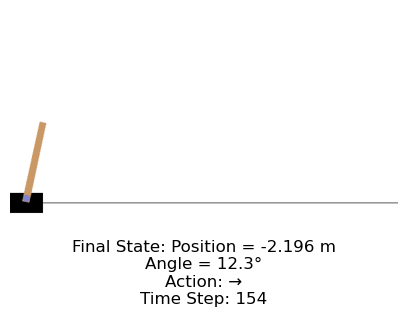

In [26]:
animate_policy(env, lin_policy, **CONFIG['animation'])

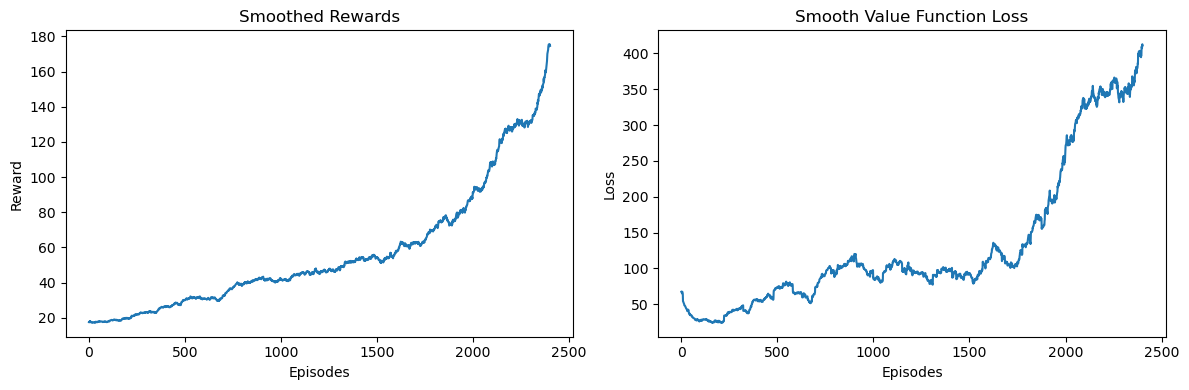

In [27]:
plot_stats(stats_lin, CONFIG['plots_info'], 100)

## MLP Policy

In [29]:
s_dims = env.observation_space.shape[0]
a_dims = env.action_space.n

mlp_policy = MLPPolicyDiscrete(s_dims, a_dims, CONFIG['MLPPolicy_hidden_sizes'])
stats_mlp = VanillaPolicyGradient(env, mlp_policy, **CONFIG['VPG']['mlp'])

Episode : 1000/1000 (100.00%)

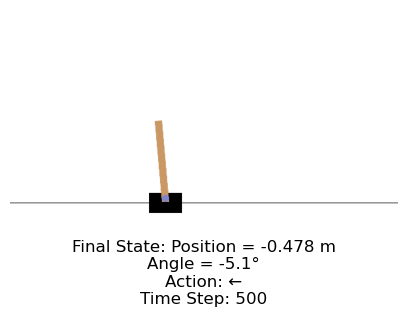

In [30]:
animate_policy(env, mlp_policy, **CONFIG['animation'])

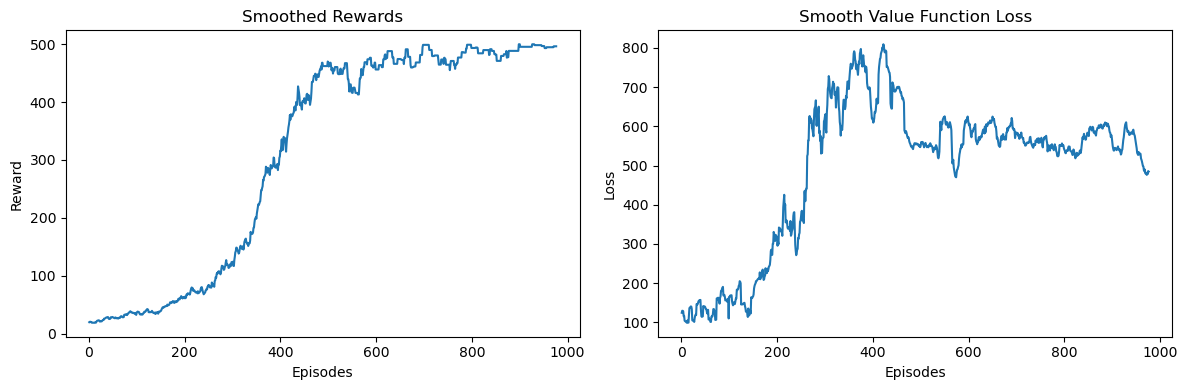

In [32]:
plot_stats(stats_mlp, CONFIG['plots_info'], 25)